Code to run MC_data_collection.py
Clone PyStochasticVolatility first.


In [ ]:
import os 
os.getcwd()
# make sure it is /content

'/content'

In [ ]:
# Clone repository. 
!git clone https://github.com/Dagalon/PyStochasticVolatility.git

Cloning into 'PyStochasticVolatility'...
remote: Enumerating objects: 2172, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 2172 (delta 161), reused 143 (delta 75), pack-reused 1923
Receiving objects: 100% (2172/2172), 3.52 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (1421/1421), done.


In [ ]:
%cd 'PyStochasticVolatility'

/content/PyStochasticVolatility/PyStochasticVolatility


In [ ]:
# Mount Google Drive. 
# your .csv will be saved in your Google Drive root folder.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# VERY IMPORTANT.
!pip install numba-scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# installing dependencies 
# !pip install time 
# !pip install prettytable
# !pip install tabulate
!pip install sobol_seq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
#MP MC Code
from tabulate import tabulate
from MC_Engines.MC_Heston import Heston_Engine
from Instruments.EuropeanInstruments import EuropeanOption, TypeSellBuy, TypeEuropeanOption
from Tools import Types
from Tools import RNG
from prettytable import PrettyTable
from time import time
import numpy as np
from tqdm import tqdm

# Initializations
epsilon = 1.1  # volatility of volatility 
k = 0.5 # rate of mean reversion 
rho = -0.9 # correlation parameter 
v0 = 0.05 # initial vol
theta = 0.05 # long term vol

f0 = 100 # initial spot price
T = 2 # time to maturity 

seed = 123456789

delta = 1.0 / 32.0
no_time_steps = int(T / delta)
no_paths = 10000
strike = 120.0

# Random Generator
rnd_generator = RNG.RndGenerator(seed)

# Vector of parameters
parameters = [k, # rate of mean reversion
              theta, # long-term variance 
              epsilon,  # volatility of volatility (nu in the book?)
              rho] 

notional = 1.0

# Spot price parameters
lower = 70
upper = 180
num = 10000
spots = np.linspace(lower, upper, num).reshape((-1, 1)) # create an equally spaced interval of 100 points, ranging from 50 to 175

# Arrays to store results
option_prices = np.zeros(num)
standard_errors = np.zeros(num)
deltas = np.zeros(num)
gammas = np.zeros(num)
asset_prices = np.zeros(num)

start_time = time()
# Run the simulation with tqdm progress bar
for i in tqdm(range(num)):
  # European option
    spot_price = spots[i][0]  # Extract the spot price from the array
    european_option = EuropeanOption(strike, notional, TypeSellBuy.BUY, TypeEuropeanOption.CALL, spot_price, T)

    
    # Compute price using MC
    map_heston_output = Heston_Engine.get_path_multi_step(0.0, # initial time 
                                                          T, # time to maturity 
                                                          parameters, # vector of parameters 
                                                          spot_price, 
                                                          v0, # initial volatility 
                                                          no_paths, # number of simulated asset paths 
                                                          no_time_steps, # number of time steps
                                                          Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC, # sampling method: antithetic sampling of standard normal 
                                                          rnd_generator)  
    
    # get option prices using the simulated asset prices from get_path_multi_step
    result = european_option.get_price(map_heston_output[Types.HESTON_OUTPUT.PATHS])
    
    # Compute price, delta and gamma by MC and Malliavin in Heston model
    malliavin_delta = european_option.get_malliavin_delta(map_heston_output[Types.HESTON_OUTPUT.PATHS],
                                                          map_heston_output[Types.HESTON_OUTPUT.DELTA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL])
    malliavin_gamma = european_option.get_malliavin_gamma(map_heston_output[Types.HESTON_OUTPUT.PATHS],
                                                          map_heston_output[Types.HESTON_OUTPUT.GAMMA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL])
    
    # Store results in arrays
    option_prices[i] = result[0]
    standard_errors[i] = result[1]
    deltas[i] = malliavin_delta[0]
    gammas[i] = malliavin_gamma[0]
    asset_prices[i] = np.mean([sub_array[-1] for sub_array in map_heston_output[Types.HESTON_OUTPUT.PATHS]]) # average of last value for 200,000 simulations of asset prices

# Print the collected results
print("MC (Prices) and Malliavin method (Greeks).")
print("Options Prices:\n", option_prices)
print("Standard Errors:\n", standard_errors)
print("Deltas:\n", deltas)
print("Gammas:\n", gammas)
print("Asset Prices in First Time Period:\n", asset_prices)

end_time = time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

# # Save results to CSV
np.savetxt("malliavin_option_prices_14.csv", option_prices, delimiter=",")
np.savetxt("malliavin_standard_errors_14.csv", standard_errors, delimiter=",")
np.savetxt("malliavin_deltas_14.csv", deltas, delimiter=",")
np.savetxt("malliavin_gammas_14.csv", gammas, delimiter=",")
np.savetxt("malliavin_asset_prices_14.csv", asset_prices, delimiter=",")

print("Results saved to CSV files.")

#9: 70-300 asset prices 
#10: Time step reverted back 


100%|██████████| 10000/10000 [1:37:08<00:00,  1.72it/s]


MC (Prices) and Malliavin method (Greeks).
Options Prices:
 [6.34956395e-04 1.88572543e-03 1.03508643e-03 ... 6.30710953e+01
 6.30875463e+01 6.34788590e+01]
Standard Errors:
 [0.00063494 0.00144609 0.00053785 ... 0.17536519 0.17485175 0.17293177]
Deltas:
 [9.47850914e-05 2.84037153e-04 3.57531714e-04 ... 9.69872898e-01
 9.69045594e-01 9.73293661e-01]
Gammas:
 [0.         0.         0.         ... 0.0009262  0.         0.00092649]
Asset Prices in First Time Period:
 [ 70.00668213  70.06097626  70.21012368 ... 179.35638936 179.28430158
 179.97196706]
Execution Time: 5828.408767461777 seconds
Results saved to CSV files.


In [ ]:
#MP MC Code
from tabulate import tabulate
from MC_Engines.MC_Heston import Heston_Engine
from Instruments.EuropeanInstruments import EuropeanOption, TypeSellBuy, TypeEuropeanOption
from Tools import Types
from Tools import RNG
from prettytable import PrettyTable
from time import time
import numpy as np
from tqdm import tqdm

# Initializations
epsilon = 1.1  # volatility of volatility 
k = 0.5 # rate of mean reversion 
rho = -0.9 # correlation parameter 
v0 = 0.05 # initial vol
theta = 0.05 # long term vol

f0 = 100 # initial spot price
T = 2 # time to maturity 

seed = 123456789

delta = 1.0 / 32.0
no_time_steps = int(T / delta)
no_paths = 10000
strike = 120.0

# Random Generator
rnd_generator = RNG.RndGenerator(seed)

# Vector of parameters
parameters = [k, # rate of mean reversion
              theta, # long-term variance 
              epsilon,  # volatility of volatility (nu in the book?)
              rho] 

notional = 1.0

# European option
european_option = EuropeanOption(strike, notional, TypeSellBuy.BUY, TypeEuropeanOption.CALL, f0, T)

# Spot price parameters
lower = 70
upper = 180
num = 10000
spots = np.linspace(lower, upper, num).reshape((-1, 1)) # create an equally spaced interval of 100 points, ranging from 50 to 175

# Arrays to store results
option_prices = np.zeros(num)
standard_errors = np.zeros(num)
deltas = np.zeros(num)
gammas = np.zeros(num)
asset_prices = np.zeros(num)

start_time = time()
# Run the simulation with tqdm progress bar
for i in tqdm(range(num)):
    spot_price = spots[i][0]  # Extract the spot price from the array
    
    # Compute price using MC
    map_heston_output = Heston_Engine.get_path_multi_step(0.0, # initial time 
                                                          T, # time to maturity 
                                                          parameters, # vector of parameters 
                                                          spot_price, 
                                                          v0, # initial volatility 
                                                          no_paths, # number of simulated asset paths 
                                                          no_time_steps, # number of time steps
                                                          Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC, # sampling method: antithetic sampling of standard normal 
                                                          rnd_generator)  
    
    # get option prices using the simulated asset prices from get_path_multi_step
    result = european_option.get_price(map_heston_output[Types.HESTON_OUTPUT.PATHS])
    
    # Compute price, delta and gamma by MC and Malliavin in Heston model
    malliavin_delta = european_option.get_malliavin_delta(map_heston_output[Types.HESTON_OUTPUT.PATHS],
                                                          map_heston_output[Types.HESTON_OUTPUT.DELTA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL])
    malliavin_gamma = european_option.get_malliavin_gamma(map_heston_output[Types.HESTON_OUTPUT.PATHS],
                                                          map_heston_output[Types.HESTON_OUTPUT.GAMMA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL])
    
    # Store results in arrays
    option_prices[i] = result[0]
    standard_errors[i] = result[1]
    deltas[i] = malliavin_delta[0]
    gammas[i] = malliavin_gamma[0]
    asset_prices[i] = np.mean([sub_array[-1] for sub_array in map_heston_output[Types.HESTON_OUTPUT.PATHS]]) # average of last value for 200,000 simulations of asset prices

# Print the collected results
print("MC (Prices) and Malliavin method (Greeks).")
print("Options Prices:\n", option_prices)
print("Standard Errors:\n", standard_errors)
print("Deltas:\n", deltas)
print("Gammas:\n", gammas)
print("Asset Prices in First Time Period:\n", asset_prices)

end_time = time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

# # Save results to CSV
np.savetxt("malliavin_option_prices_15.csv", option_prices, delimiter=",")
np.savetxt("malliavin_standard_errors_15.csv", standard_errors, delimiter=",")
np.savetxt("malliavin_deltas_15.csv", deltas, delimiter=",")
np.savetxt("malliavin_gammas_15.csv", gammas, delimiter=",")
np.savetxt("malliavin_asset_prices_15.csv", asset_prices, delimiter=",")

print("Results saved to CSV files.")

#9: 70-300 asset prices 
#10: Time step reverted back 


100%|██████████| 10000/10000 [1:38:14<00:00,  1.70it/s]

MC (Prices) and Malliavin method (Greeks).
Options Prices:
 [6.34956395e-04 1.88572543e-03 1.03508643e-03 ... 6.30710953e+01
 6.30875463e+01 6.34788590e+01]
Standard Errors:
 [0.00063494 0.00144609 0.00053785 ... 0.17536519 0.17485175 0.17293177]
Deltas:
 [6.63495640e-05 1.98857254e-04 2.50350864e-04 ... 1.74555782e+00
 1.74417546e+00 1.75192859e+00]
Gammas:
 [0.         0.         0.         ... 0.00300007 0.         0.00300051]
Asset Prices in First Time Period:
 [ 70.00668213  70.06097626  70.21012368 ... 179.35638936 179.28430158
 179.97196706]
Execution Time: 5894.020149946213 seconds
Results saved to CSV files.


In [ ]:
%ls

ls: cannot access 'gdrive': Transport endpoint is not connected
drive/  gdrive/  PyStochasticVolatility/  sample_data/


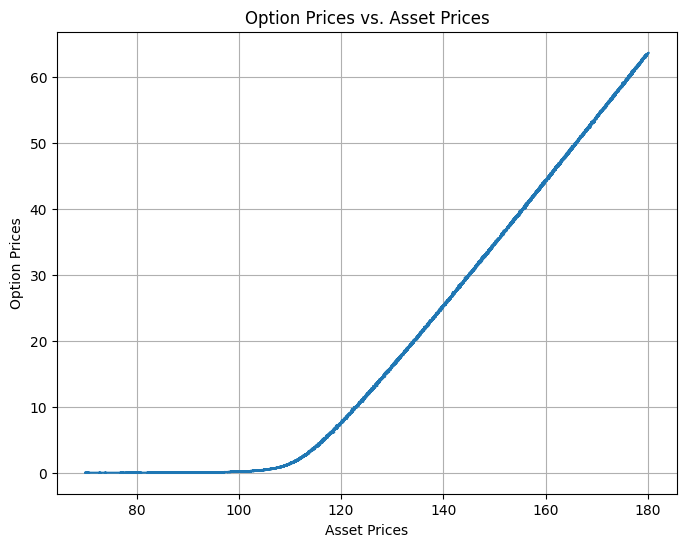

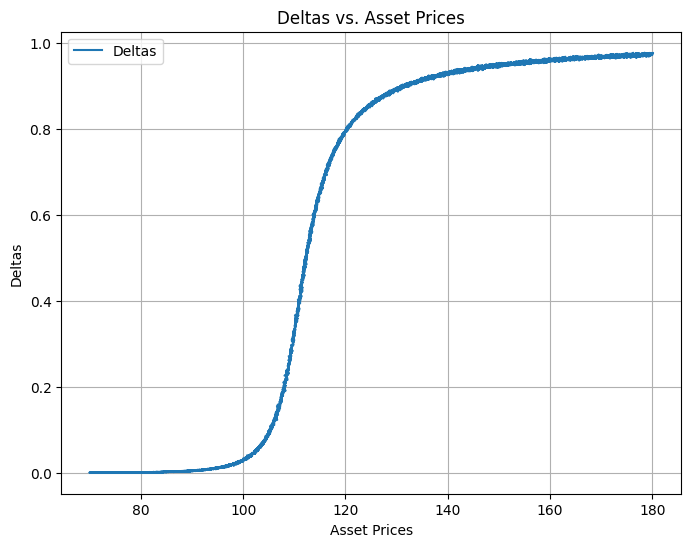

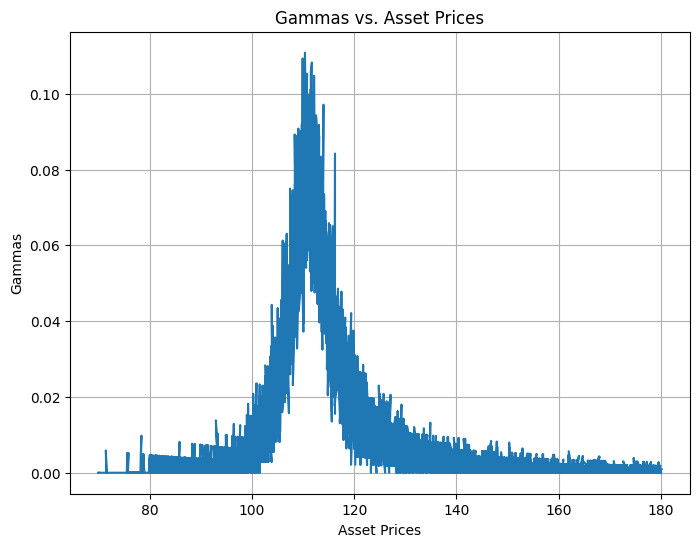

In [23]:
import matplotlib.pyplot as plt 


# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

#other_deltas = np.loadtxt('drive/MyDrive/malliavin_deltas_11.csv', delimiter=',')

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas, label='Deltas')
#plt.plot(asset_prices, other_deltas, label='Other Deltas')
plt.title('Deltas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.legend()  # Add legend to differentiate the lines
plt.show()


# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()

In [ ]:
max(deltas)

0.9540081564180815

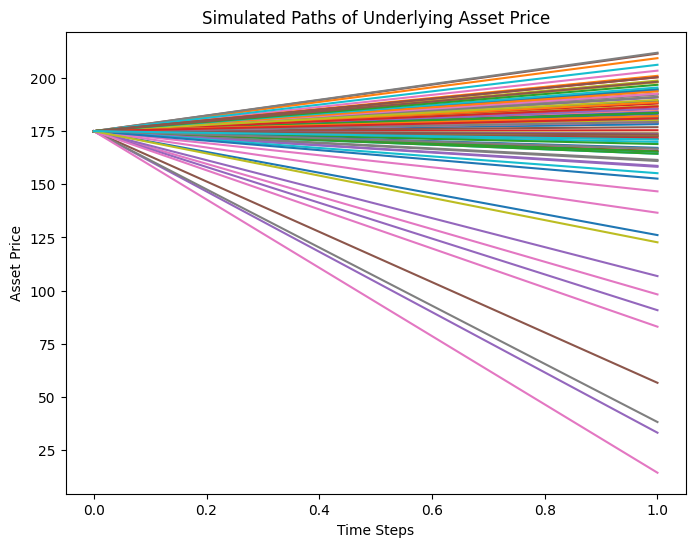

In [ ]:
# Plotting paths of underlying asset price over time 

from matplotlib import pyplot as plt
# map_heston_output = Heston_Engine.get_path_multi_step(0.0, # initial time 
#                                                           T, # time to maturity 
#                                                           parameters, # vector of parameters 
#                                                           100, 
#                                                           v0, # initial volatility 
#                                                           no_paths, # number of simulated asset paths 
#                                                           no_time_steps, # number of time steps
#                                                           Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC, # sampling method: antithetic sampling of standard normal 
#                                                           rnd_generator)  

simulated_paths = map_heston_output[Types.HESTON_OUTPUT.PATHS]
# Plot the simulated paths
plt.figure(figsize=(8, 6))
for i in range(100):
    plt.plot(simulated_paths[i])
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.title('Simulated Paths of Underlying Asset Price')
plt.show()

In [ ]:
# Plotting paths of underlying asset price over time 

from matplotlib import pyplot as plt
# Plot the simulated paths
plt.figure(figsize=(8, 6))
for i in range(20):
    plt.plot(asset_prices[i])
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.title('Simulated Paths of Underlying Asset Price')
plt.show()

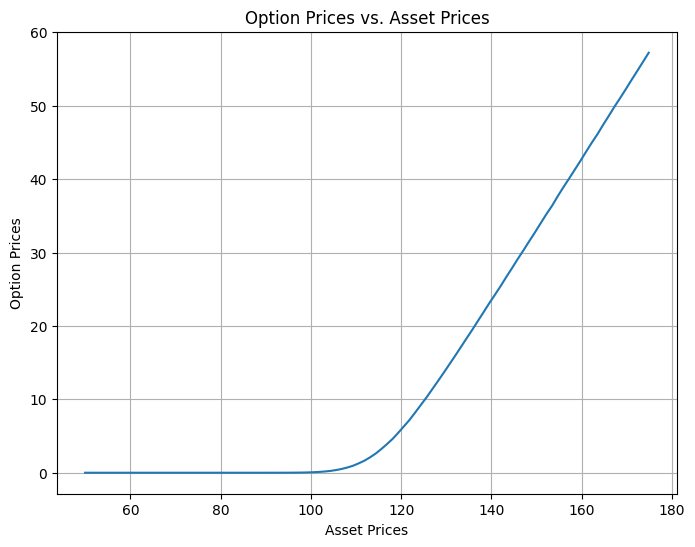

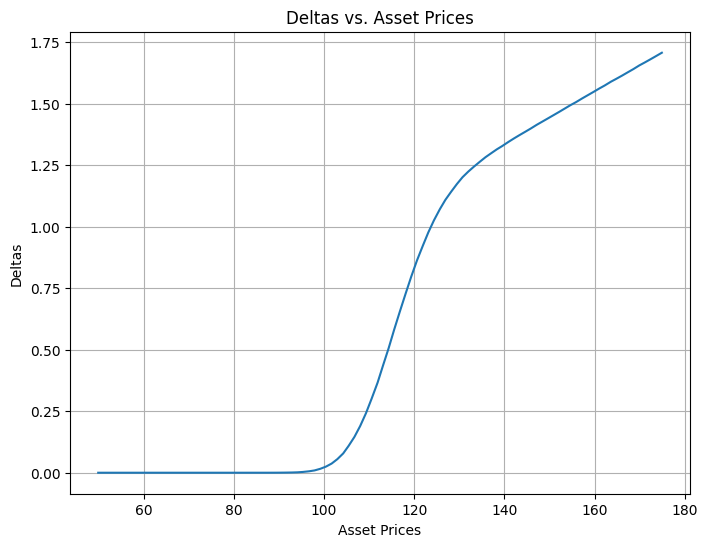

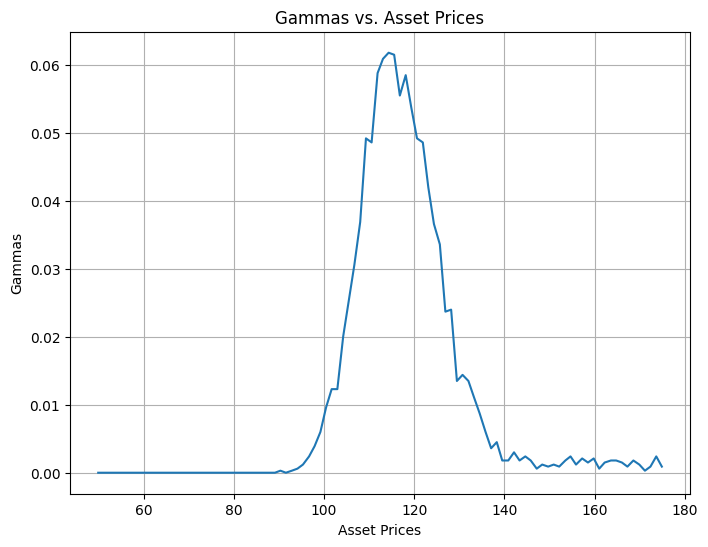

In [ ]:
import matplotlib.pyplot as plt 

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


In [ ]:
option_prices

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.76728656e-05, 0.00000000e+00, 3.05333919e-05,
       8.52917010e-05, 6.87501023e-05, 1.00173873e-04, 2.27715227e-04,
       4.24502875e-04, 1.03251587e-03, 1.78593452e-03, 3.61308476e-03,
       6.26787336e-03, 1.31341951e-02, 2.26893431e-02, 4.00314420e-02,
       6.50497570e-02, 1.03405096e-01, 1.60131543e-01, 2.39531417e-01,
       3.52819237e-01, 5.00305865e-01, 7.02164903e-01, 9.41842244e-01,
       1.26382780e+00, 1.64320348e+00, 2.08172081e+00, 2.59257130e+00,
       3.19537360e+00, 3.86799342e+00, 4.60584657e+00, 5.43380123e+00,
      

# Everything beyond is just experimentation

In [ ]:
# Upload: MC_data_collection.py to content/PyStochasticVolatility. 
!python /content/PyStochasticVolatility/MC_data_collection_2.py

# Troubleshooting. Files tab (folder icon, left side of screen) -> PyStochasticVolatility -> MC_data_collection.py. Click on it and it should appear as a pop-up that you can edit. 
# Change num_simulations to 3-5k. 

# For later:
  # Asset prices? 
  # Initializations? 

Options Prices:
 [3.78692090e-03 5.21300031e-03 5.55347979e-03 5.91034200e-03
 6.28769241e-03 6.68897507e-03 7.12212363e-03 7.58417491e-03
 8.08436437e-03 8.63776518e-03 9.23637488e-03 9.88153586e-03
 1.05701465e-02 1.13177474e-02 1.21339419e-02 1.30152362e-02
 1.39539633e-02 1.49433274e-02 1.60099832e-02 1.71561184e-02
 1.83967131e-02 1.97294545e-02 2.11948876e-02 2.27533488e-02
 2.44225840e-02 2.62188163e-02 2.81381025e-02 3.02103057e-02
 3.24227887e-02 3.47875574e-02 3.73124346e-02 4.00022985e-02
 4.29011978e-02 4.60215397e-02 4.93975969e-02 5.30670451e-02
 5.70106614e-02 6.12376893e-02 6.57740918e-02 7.06729334e-02
 7.59236430e-02 8.15815811e-02 8.76765093e-02 9.43020097e-02
 1.01505957e-01 1.09286743e-01 1.17680900e-01 1.26772691e-01
 1.36649419e-01 1.47346147e-01 1.59016223e-01 1.71665628e-01
 1.85453906e-01 2.00498693e-01 2.16999499e-01 2.35052133e-01
 2.54788693e-01 2.76405608e-01 3.00087739e-01 3.26039088e-01
 3.54650265e-01 3.86256413e-01 4.21336328e-01 4.60266672e-01
 5.0338

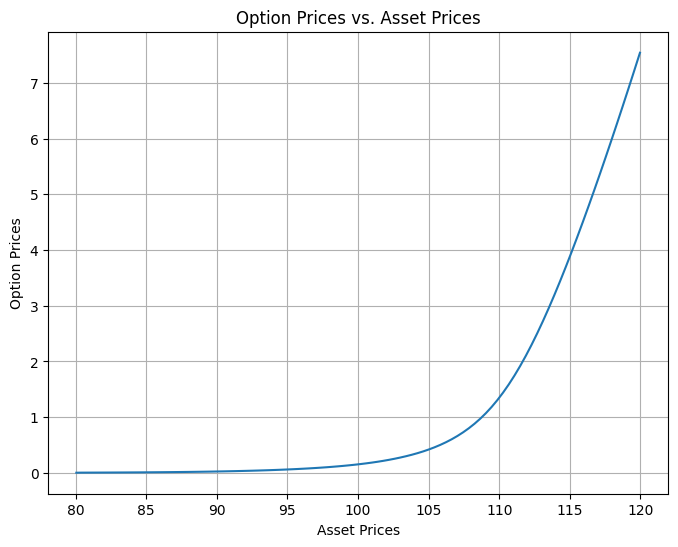

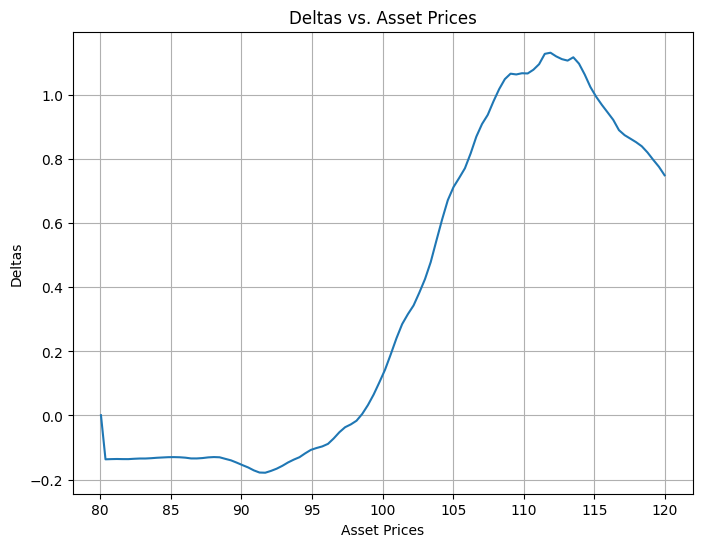

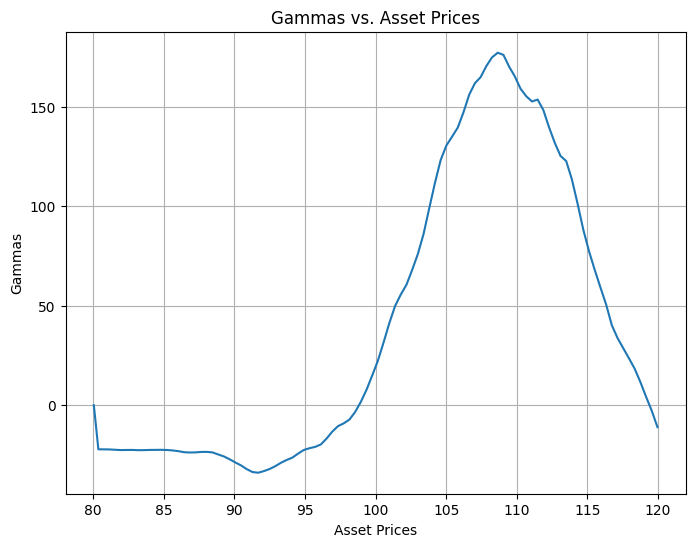

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


In [ ]:
# Upload: MC_data_collection.py to content/PyStochasticVolatility. 
!python /content/PyStochasticVolatility/MC_data_collection_malliavin.py

MC (Prices) and Malliavin method (Greeks).
Options Prices:
 [3.78692090e-03 4.92415694e-03 3.63904251e-03 4.72430996e-03
 3.86000119e-03 5.45021770e-03 4.76832836e-03 5.02142371e-03
 4.57466219e-03 5.08158703e-03 5.17556049e-03 5.55770006e-03
 5.08370386e-03 4.39326037e-03 5.35760853e-03 5.14467477e-03
 4.48501984e-03 4.86646050e-03 4.98956577e-03 6.08930864e-03
 4.88384400e-03 5.59249640e-03 5.83371342e-03 5.51019563e-03
 5.20774089e-03 4.83339701e-03 6.63443619e-03 6.05631992e-03
 5.68107801e-03 5.31117356e-03 6.60886478e-03 6.78741426e-03
 7.11403478e-03 7.32114943e-03 6.00917955e-03 6.56261610e-03
 5.28949238e-03 6.11708768e-03 5.49744504e-03 5.63916991e-03
 6.47110744e-03 4.77148274e-03 6.58556074e-03 6.12737654e-03
 6.12118363e-03 5.93411847e-03 6.25555858e-03 7.09144746e-03
 5.74730602e-03 5.68361320e-03 6.06949287e-03 8.16891229e-03
 5.99870084e-03 6.15388074e-03 5.84067528e-03 6.69779512e-03
 7.50179834e-03 9.05744892e-03 6.70838851e-03 5.88117732e-03
 8.22318090e-03 6.5811170

In [ ]:
import csv
import os

def clean_csv_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            cleaned_rows = []
            with open(filepath, newline='', encoding='utf-8-sig') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    cleaned_row = [value.strip('\ufeff') for value in row]
                    cleaned_rows.append(cleaned_row)
            
            with open(filepath, 'w', newline='', encoding='utf-8-sig') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerows(cleaned_rows)

# Specify the directory where your .csv files are located
directory_path = 'drive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/'

clean_csv_files(directory_path)


In [ ]:
f = open('drive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_option_prices_1k.csv', mode='r')
f.read()

filecp = codecs.open(myfile, encoding = 'cp1252')
mydata = np.loadtxt(filecp, skiprows = n)

'\ufeff3.79E-03\n4.92E-03\n3.64E-03\n4.72E-03\n3.86E-03\n5.45E-03\n4.77E-03\n5.02E-03\n4.57E-03\n5.08E-03\n5.18E-03\n5.56E-03\n5.08E-03\n4.39E-03\n5.36E-03\n5.14E-03\n4.49E-03\n4.87E-03\n4.99E-03\n6.09E-03\n4.88E-03\n5.59E-03\n5.83E-03\n5.51E-03\n5.21E-03\n4.83E-03\n6.63E-03\n6.06E-03\n5.68E-03\n5.31E-03\n6.61E-03\n6.79E-03\n7.11E-03\n7.32E-03\n6.01E-03\n6.56E-03\n5.29E-03\n6.12E-03\n5.50E-03\n5.64E-03\n6.47E-03\n4.77E-03\n6.59E-03\n6.13E-03\n6.12E-03\n5.93E-03\n6.26E-03\n7.09E-03\n5.75E-03\n5.68E-03\n6.07E-03\n8.17E-03\n6.00E-03\n6.15E-03\n5.84E-03\n6.70E-03\n7.50E-03\n9.06E-03\n6.71E-03\n5.88E-03\n8.22E-03\n6.58E-03\n7.43E-03\n7.90E-03\n7.36E-03\n6.41E-03\n6.47E-03\n7.54E-03\n6.14E-03\n7.73E-03\n9.30E-03\n8.81E-03\n5.68E-03\n6.61E-03\n7.54E-03\n8.46E-03\n7.75E-03\n7.32E-03\n7.67E-03\n8.52E-03\n7.12E-03\n8.13E-03\n8.13E-03\n7.17E-03\n7.99E-03\n8.91E-03\n8.32E-03\n8.68E-03\n8.83E-03\n9.12E-03\n7.87E-03\n8.12E-03\n9.37E-03\n9.90E-03\n7.76E-03\n8.23E-03\n9.50E-03\n9.18E-03\n8.52E-03\n9.1

In [ ]:
option_prices = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_option_prices_1k.csv', encoding='utf-8-sig')
deltas = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_deltas_1k.csv', encoding='utf-8-sig')
asset_prices = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_asset_prices_1k.csv', encoding='utf-8-sig')
gammas = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_gammas_1k.csv', encoding='utf-8-sig')


In [ ]:
import csv

def remove_character_from_csv(input_file, output_file, character):
    with open(input_file, 'r') as csv_file:
        reader = csv.reader(csv_file)
        data = list(reader)

    modified_data = []
    for row in data:
        modified_row = [cell.replace(character, '') for cell in row]
        modified_data.append(modified_row)

    with open(output_file, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerows(modified_data)

    print(f"All instances of '{character}' have been removed from the CSV.")

# Usage Example
input_file = 'drive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_gammas_1k.csv'    # Replace with your input CSV file path
output_file = 'drive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_gammas_1k.csv'  # Replace with the desired output CSV file path
character_to_remove = ']'

remove_character_from_csv(input_file, output_file, character_to_remove)


All instances of ']' have been removed from the CSV.


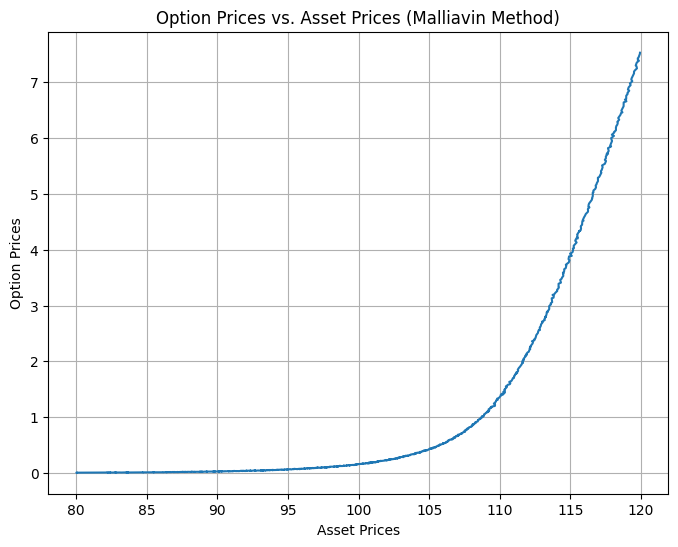

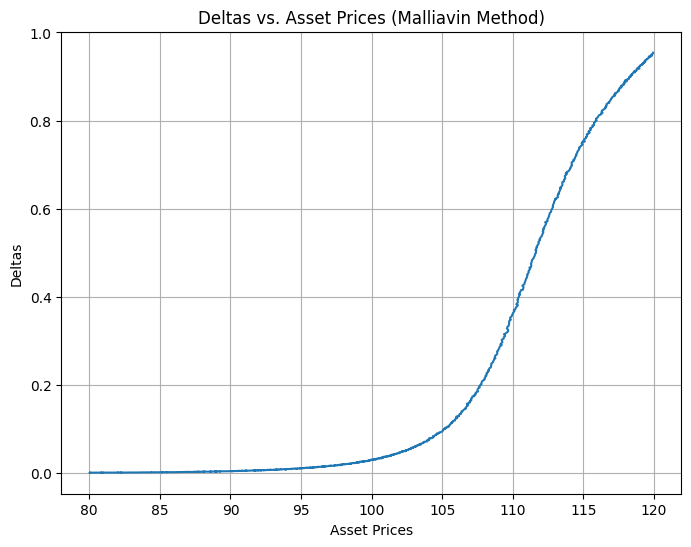

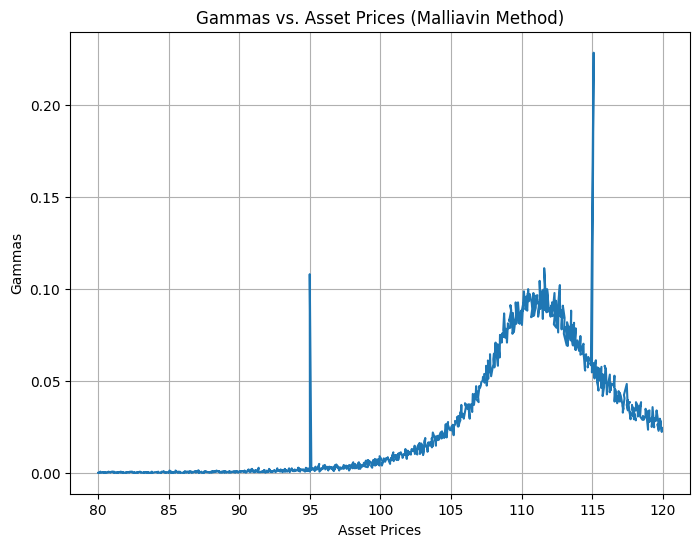

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt(option_prices)
deltas = np.loadtxt(deltas)
asset_prices = np.loadtxt(asset_prices)
gammas = np.loadtxt(gammas)

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


In [ ]:
np.savetxt("gdrive/MyDrive/malliavin_option_prices_1k.csv", option_prices, delimiter=",")
#np.savetxt("drive/MyDrive/malliavin_standard_errors_1k.csv", standard_errors, delimiter=",")
np.savetxt("gdrive/MyDrive/malliavin_deltas.csv_1k", deltas, delimiter=",")
np.savetxt("gdrive/MyDrive/malliavin_gammas.csv_1k", gammas, delimiter=",")
np.savetxt("gdrive/MyDrive/malliavin_asset_prices_1k.csv", asset_prices, delimiter=",")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
#option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


FileNotFoundError: ignored

In [ ]:
option_prices = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_option_prices_1k.csv', encoding='utf-8-sig')
deltas = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_deltas_1k.csv', encoding='utf-8-sig')
asset_prices = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_asset_prices_1k.csv', encoding='utf-8-sig')
gammas = open('gdrive/MyDrive/DSM 2022-2023 /DSMMasterProject23/Data/malliavin/malliavin_gammas_1k.csv', encoding='utf-8-sig')

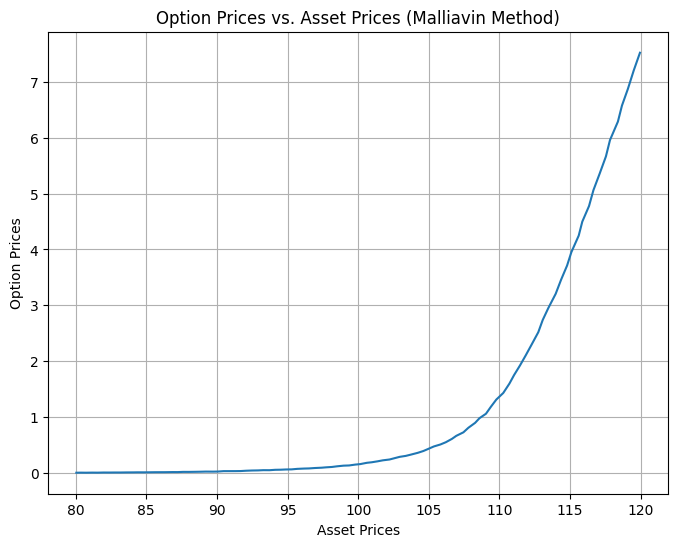

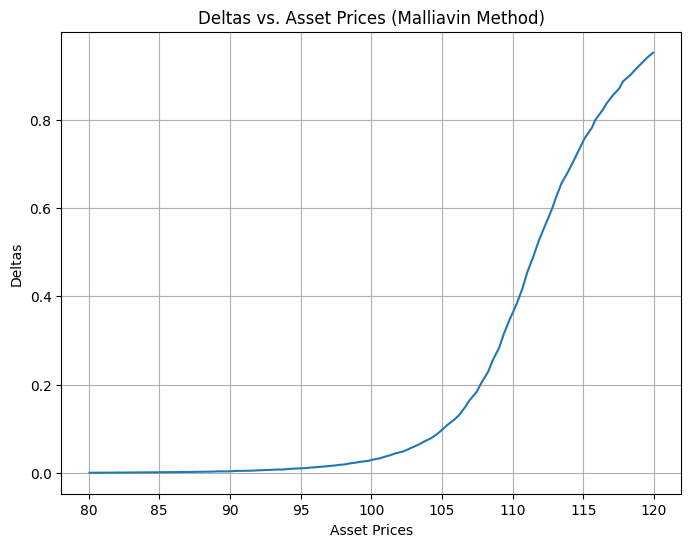

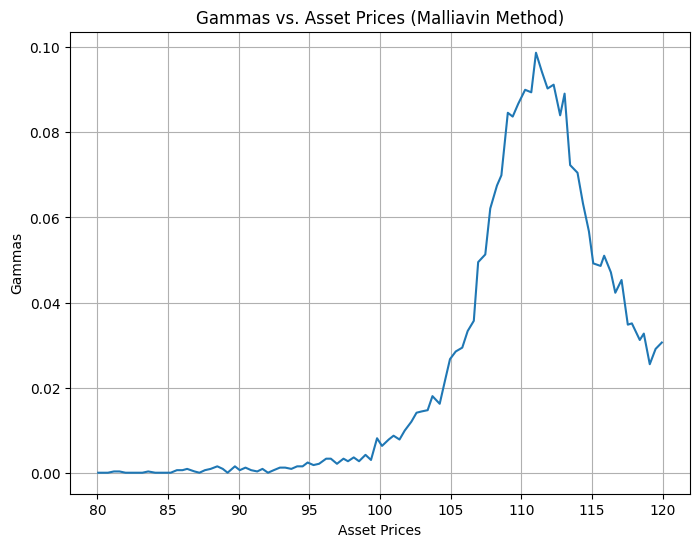

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


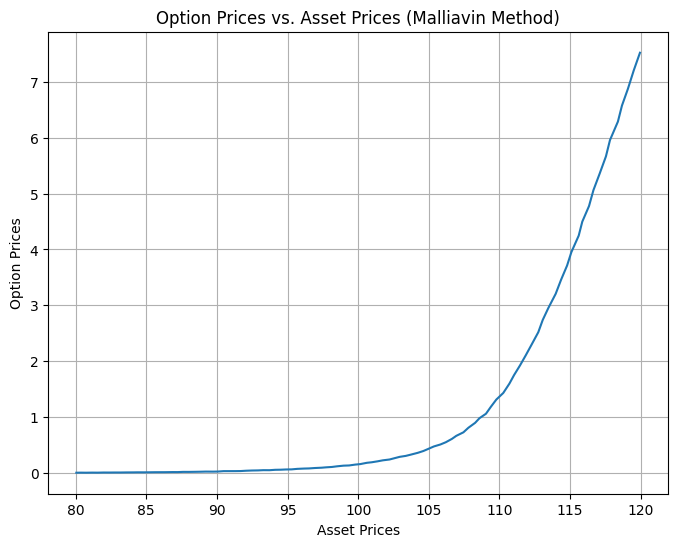

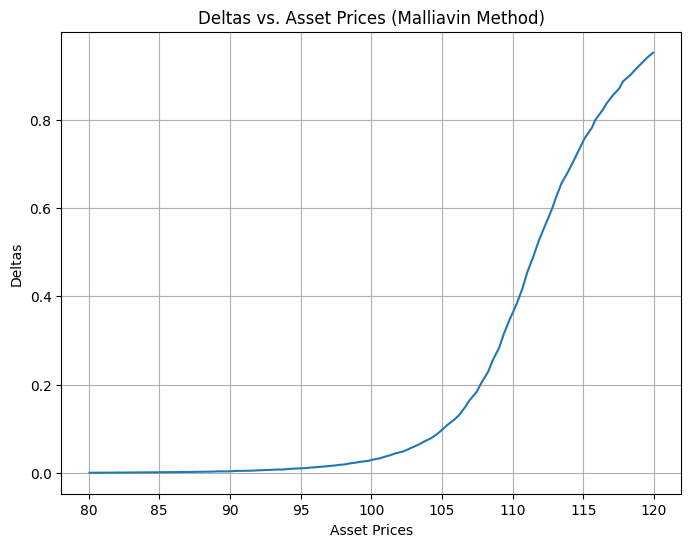

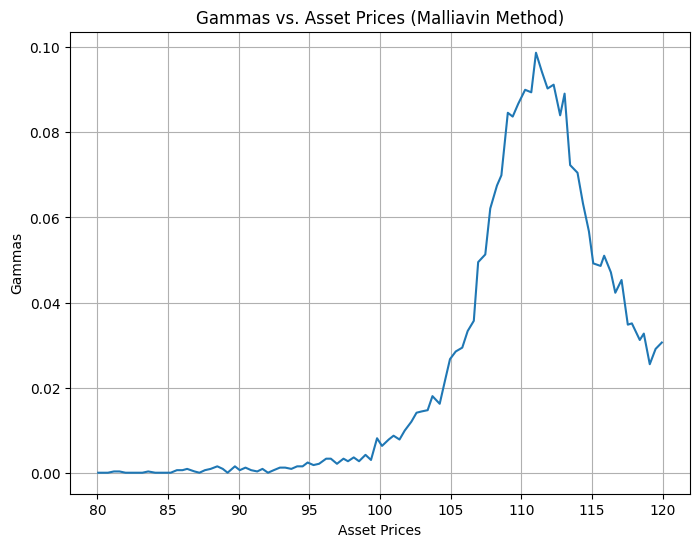

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


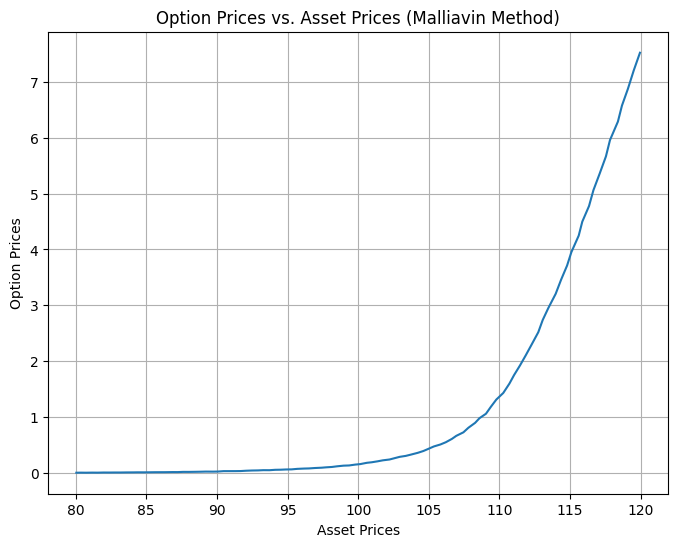

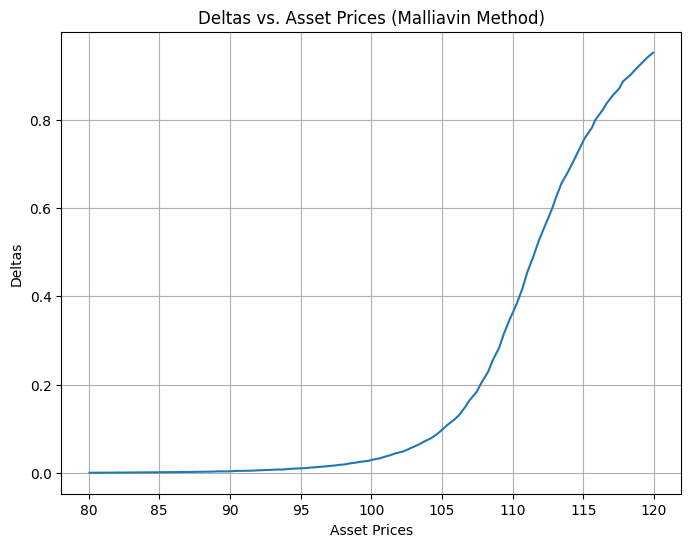

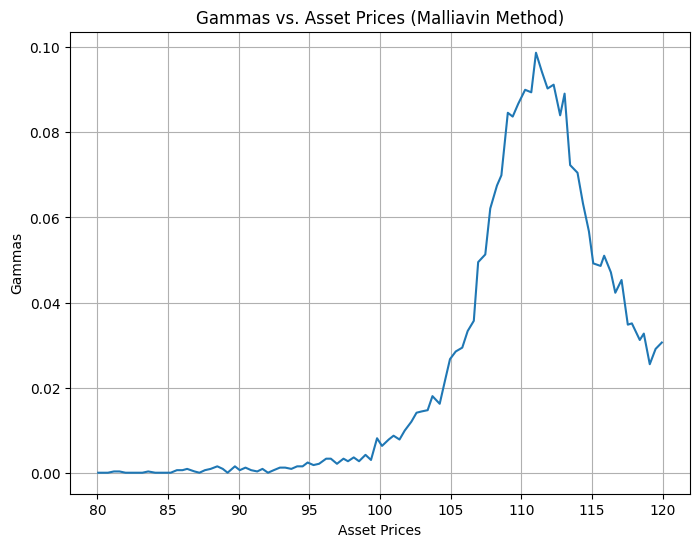

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


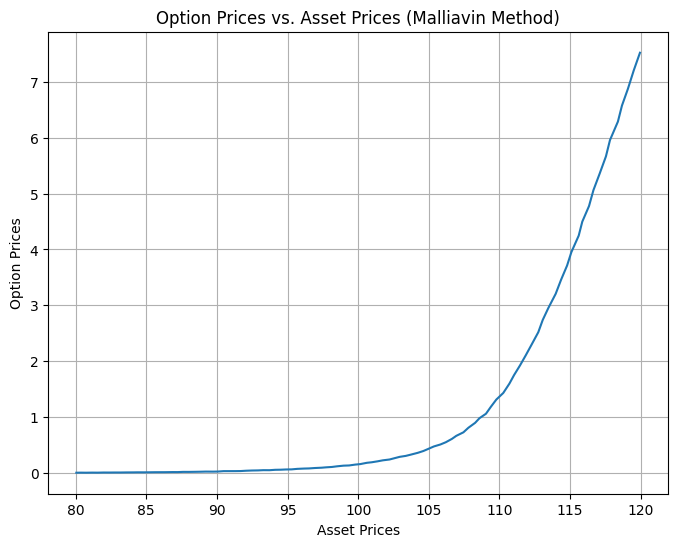

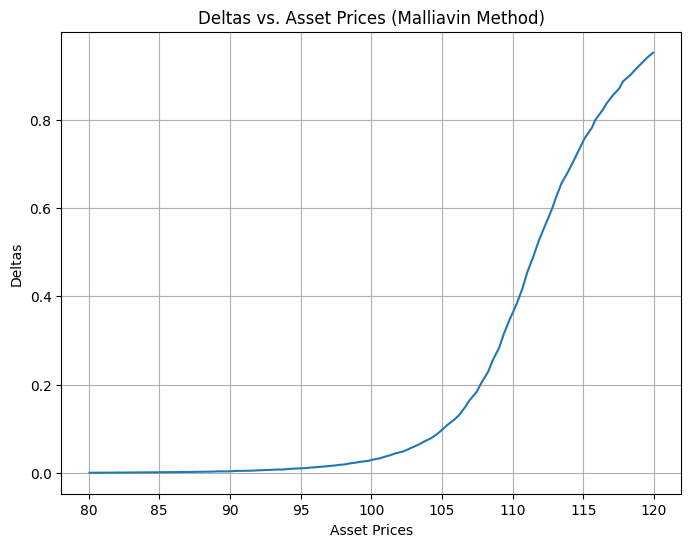

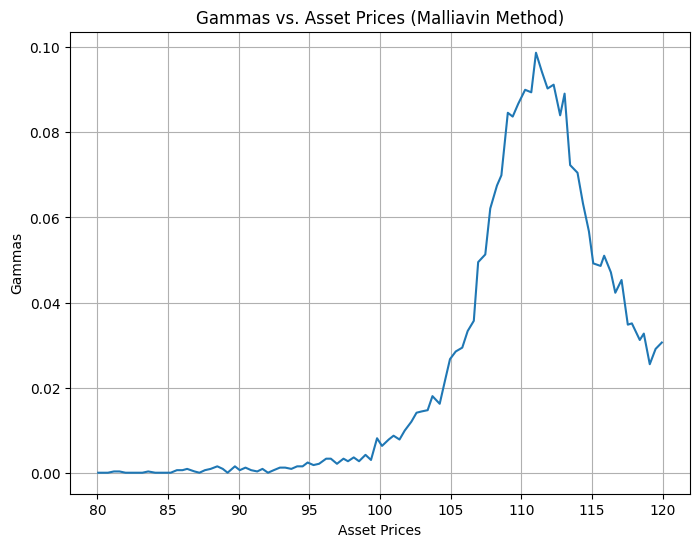

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


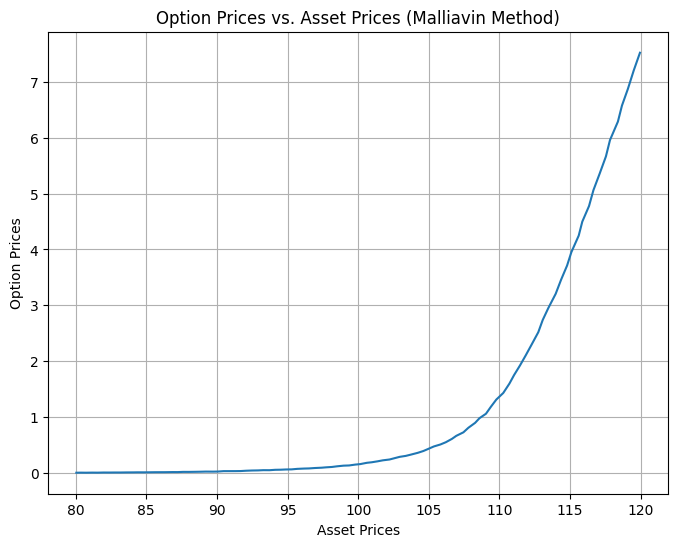

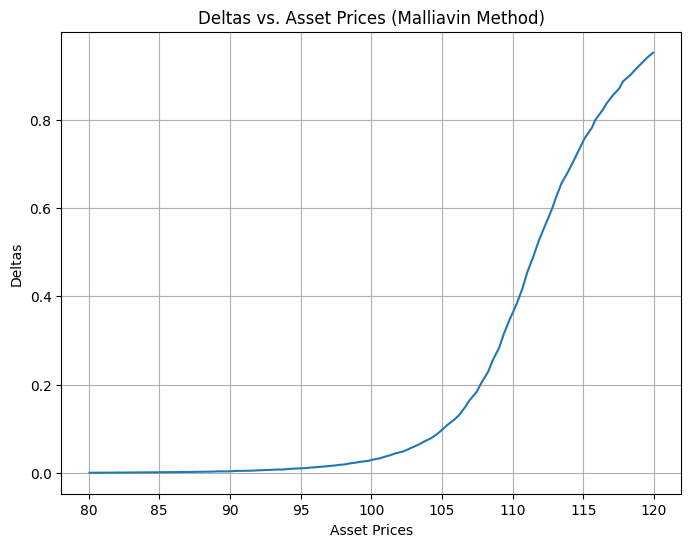

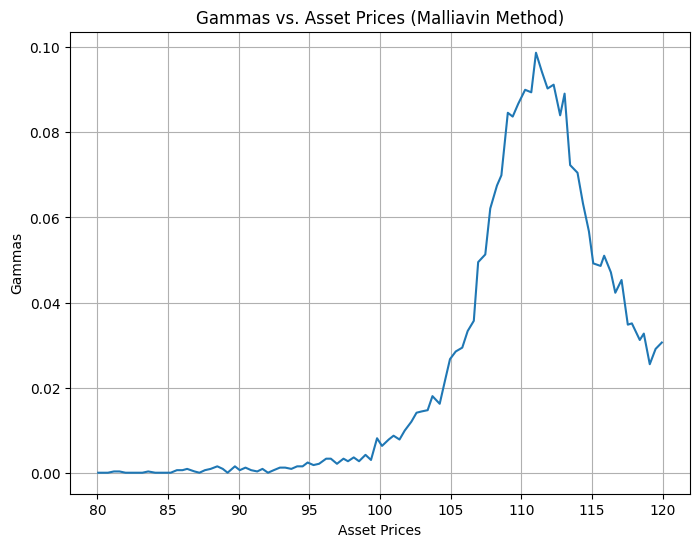

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


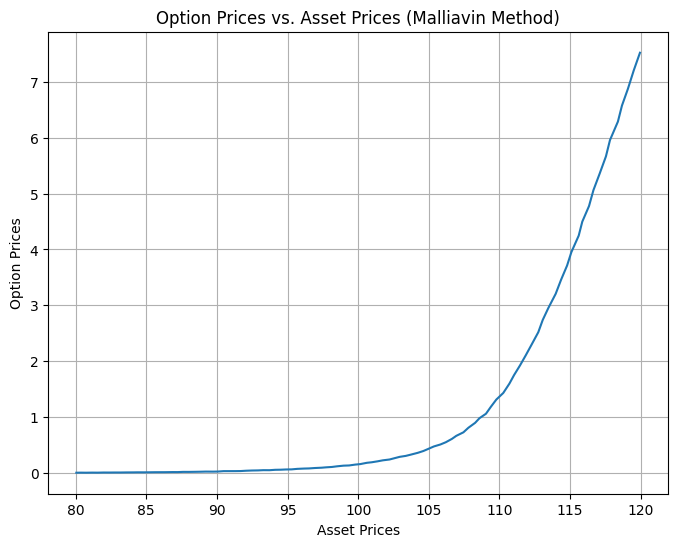

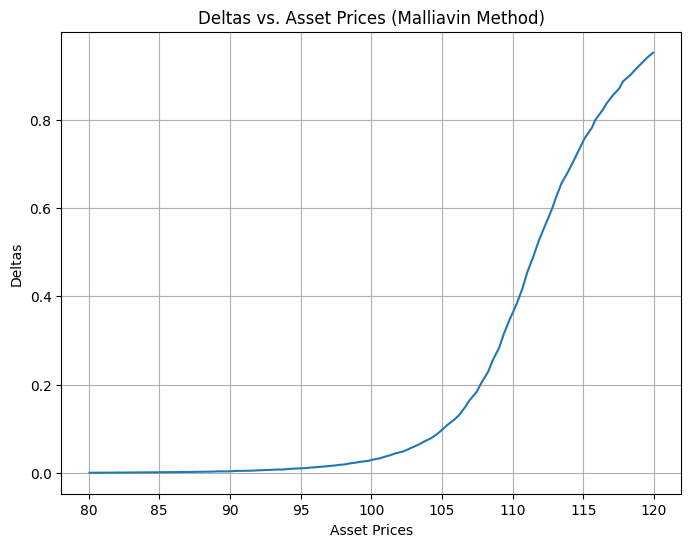

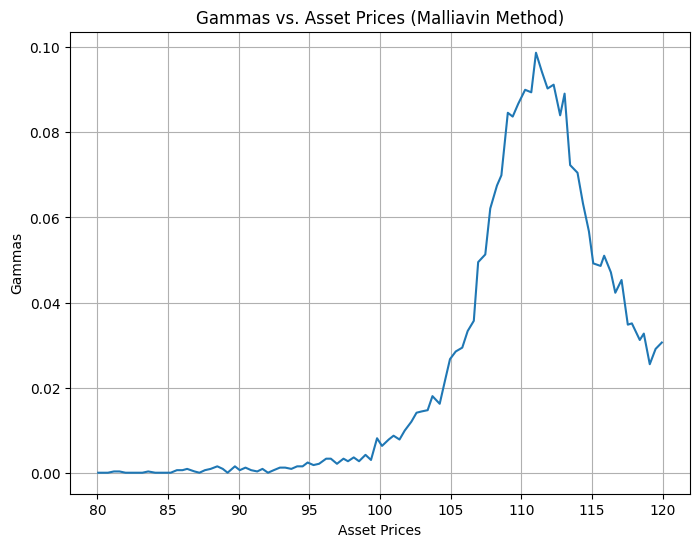

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


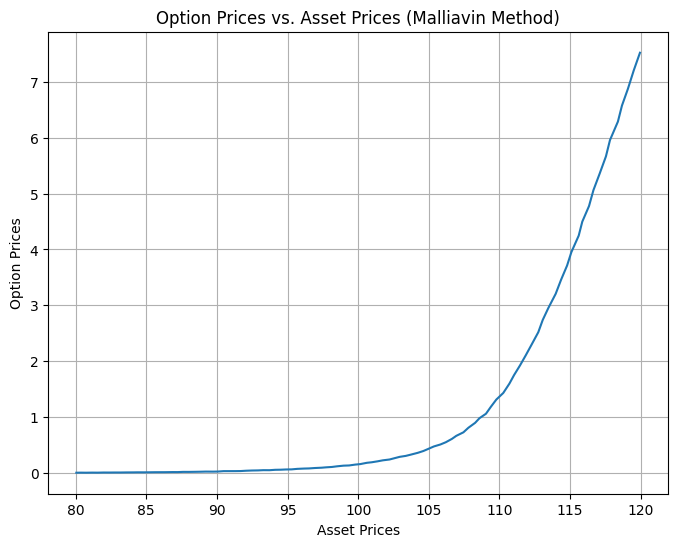

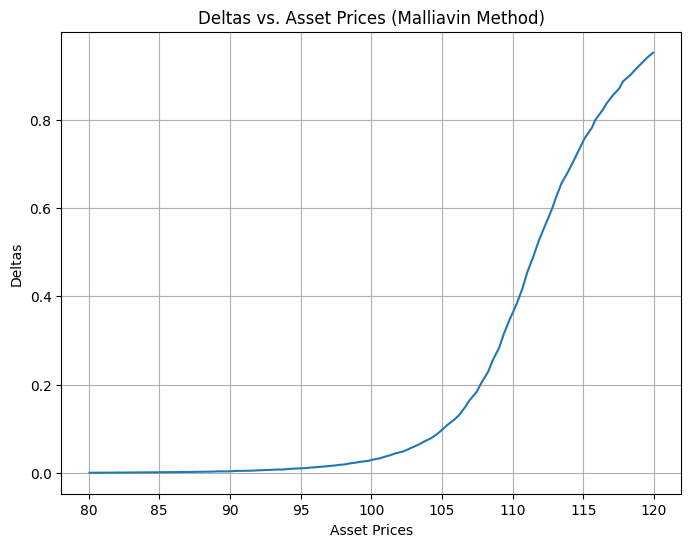

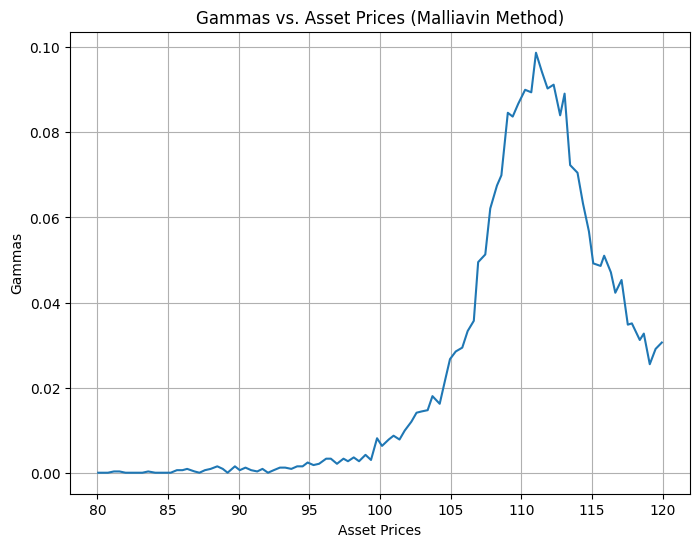

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


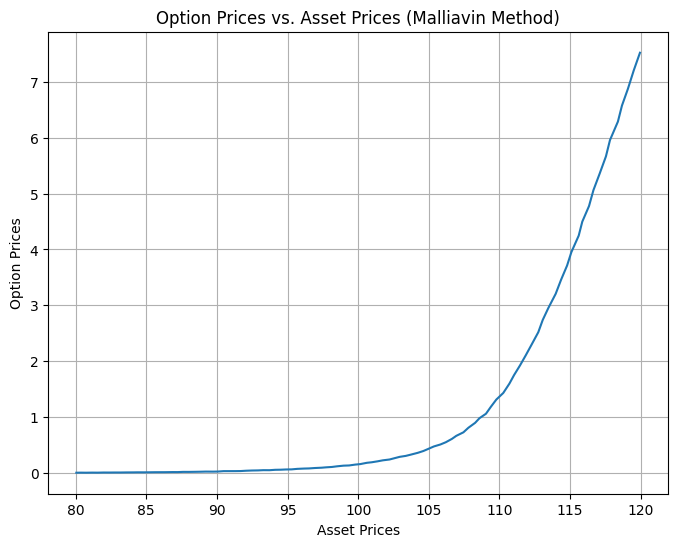

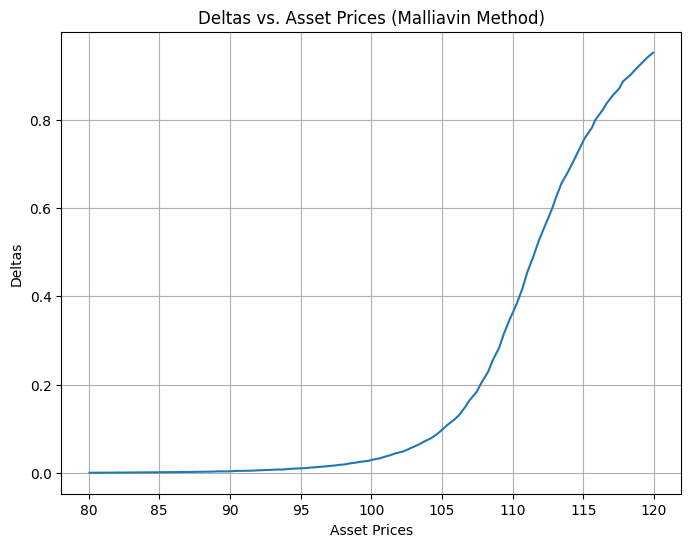

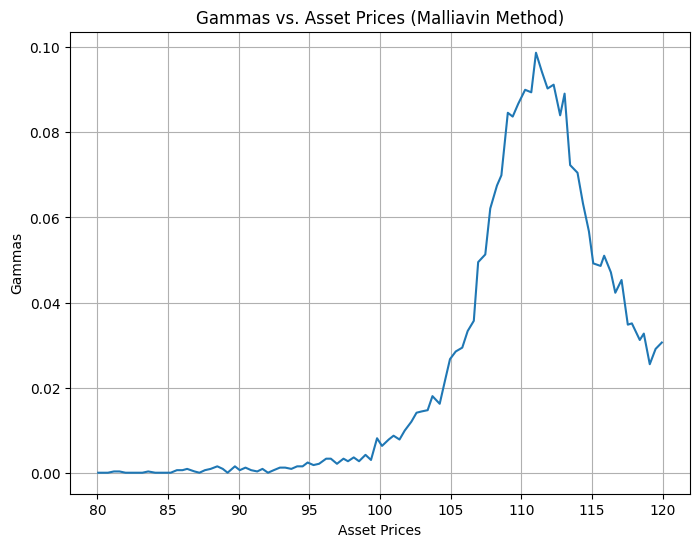

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


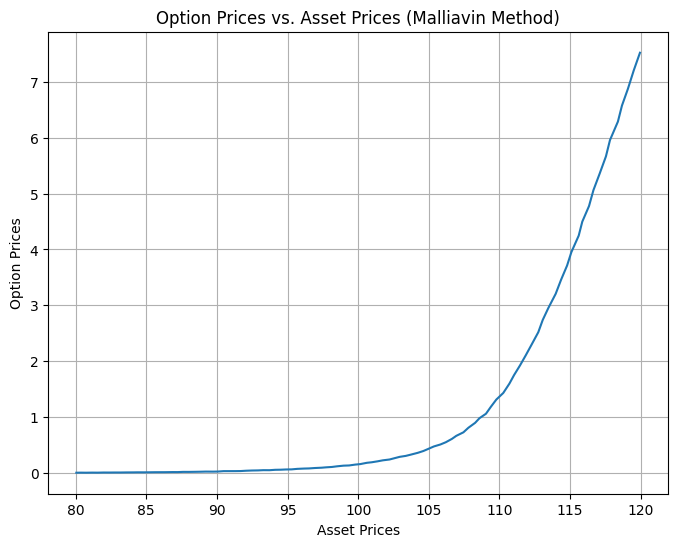

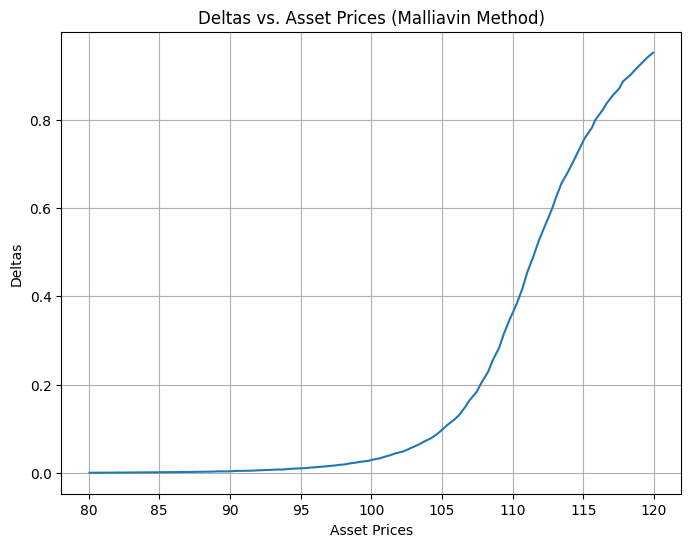

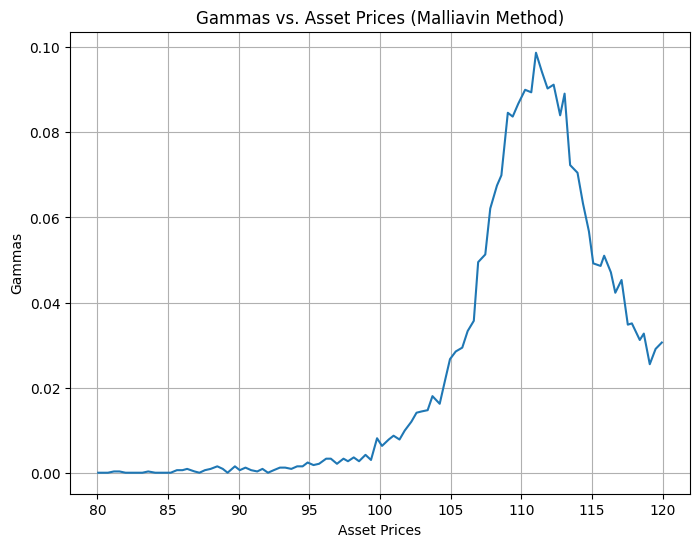

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/malliavin_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/malliavin_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/malliavin_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/malliavin_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Malliavin Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


In [ ]:
# Upload: MC_data_collection.py to content/PyStochasticVolatility. 
!python /content/PyStochasticVolatility/MC_data_collection_integ.py

Options Prices:
 [100.         100.         100.         100.         100.00000001
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.00000001 100.
 100.         100.         100.          99.99999981 100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
  99.99999983 100.00000002 100.00000012  99.99999999 100.00000003
 100.         100.         100.00000001  99.99999999  99.99999999
  99.99999999  99.99999999 100.00000014 100.00000001  99.99999994
  99.99999999  99.99999999 100.00000002 100.00000002  99.99999999
  99.99999997 100.00000001 100.00000003  99.99999998  99.99999999
  99.99999997  99.99999984  99.99999998 100.00000001  99.99999999
  99.99999997 100.00000001  99.99999991  99.99999998 100.00000003
 100.00000003 100.          99.99999996  99.99999986  99.99999999
  99.99999997  99.99999998  99.99999999  

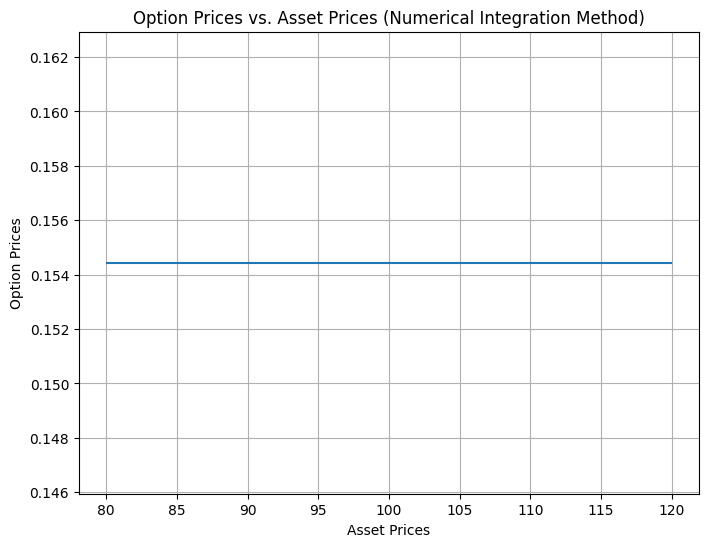

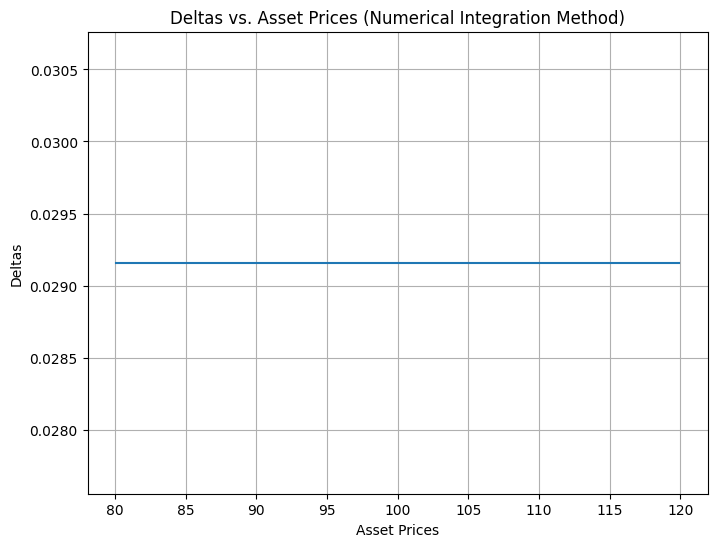

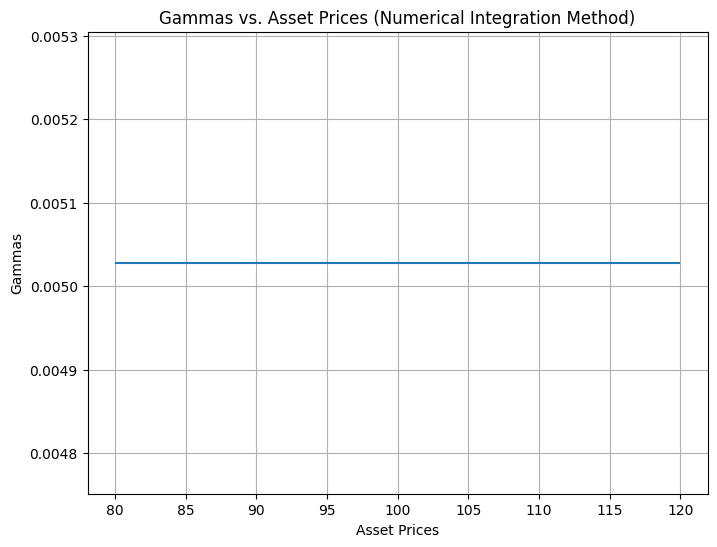

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
option_prices = np.loadtxt('drive/MyDrive/integ_option_prices.csv', delimiter=',')
deltas = np.loadtxt('drive/MyDrive/integ_deltas.csv', delimiter=',')
asset_prices = np.loadtxt('drive/MyDrive/integ_asset_prices.csv', delimiter=',')
gammas = np.loadtxt('drive/MyDrive/integ_gammas.csv', delimiter=',')

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices (Numerical Integration Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()

# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas)
plt.title('Deltas vs. Asset Prices (Numerical Integration Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.show()

# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices (Numerical Integration Method)')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()


In [ ]:
map_heston_output[Types.HESTON_OUTPUT.TIMES]

# Change from 50 - 175 
# -0.5 rho 

array([0.])

In [ ]:
option_prices